In [1]:
import pandas as pd
from sklearn.preprocessing import minmax_scale
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Conv1D, MaxPooling1D, Flatten
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/TimeSeries/UCI_Credit_Card.csv')

In [4]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

In [ ]:
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,3,1,39,0,0,0,0,...,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,...,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,1,2,2,37,4,3,2,-1,...,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,41,1,-1,0,0,...,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


In [5]:
pay_melted = df.melt(id_vars=['ID'], value_vars=['PAY_6', 'PAY_5', 'PAY_4', 'PAY_3', 'PAY_2', 'PAY_0'], value_name='pay_delay_date')

In [7]:
pay_melted

,ID,variable,pay_delay_date
0,1,PAY_6,-2
1,2,PAY_6,2
2,3,PAY_6,0
3,4,PAY_6,0
4,5,PAY_6,0
...,...,...,...
179995,29996,PAY_0,0
179996,29997,PAY_0,-1
179997,29998,PAY_0,4
179998,29999,PAY_0,1


In [8]:
bill_melted = df.melt(id_vars=['ID'], value_vars=['BILL_AMT6', 'BILL_AMT5', 'BILL_AMT4', 'BILL_AMT3', 'BILL_AMT2', 'BILL_AMT1'], value_name='bill_amount')

In [9]:
bill_melted

,ID,variable,bill_amount
0,1,BILL_AMT6,0.0
1,2,BILL_AMT6,3261.0
2,3,BILL_AMT6,15549.0
3,4,BILL_AMT6,29547.0
4,5,BILL_AMT6,19131.0
...,...,...,...
179995,29996,BILL_AMT1,188948.0
179996,29997,BILL_AMT1,1683.0
179997,29998,BILL_AMT1,3565.0
179998,29999,BILL_AMT1,-1645.0


In [10]:
pay_amt_melted = df.melt(id_vars=['ID'], value_vars=['PAY_AMT6',
       'PAY_AMT5', 'PAY_AMT4', 'PAY_AMT3', 'PAY_AMT2', 'PAY_AMT1'], value_name = 'pay_amount')

In [11]:
pay_amt_melted

,ID,variable,pay_amount
0,1,PAY_AMT6,0.0
1,2,PAY_AMT6,2000.0
2,3,PAY_AMT6,5000.0
3,4,PAY_AMT6,1000.0
4,5,PAY_AMT6,679.0
...,...,...,...
179995,29996,PAY_AMT1,8500.0
179996,29997,PAY_AMT1,1837.0
179997,29998,PAY_AMT1,0.0
179998,29999,PAY_AMT1,85900.0


In [12]:
non_cont_df = df[['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE']]

In [13]:
final_df = pd.merge(non_cont_df, pay_melted[['ID', 'pay_delay_date']], on='ID')

In [14]:
final_df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,pay_delay_date
0,1,20000.0,2,2,1,24,-2
1,1,20000.0,2,2,1,24,-2
2,1,20000.0,2,2,1,24,-1
3,1,20000.0,2,2,1,24,-1
4,1,20000.0,2,2,1,24,2
...,...,...,...,...,...,...,...
179995,30000,50000.0,1,2,1,46,0
179996,30000,50000.0,1,2,1,46,0
179997,30000,50000.0,1,2,1,46,0
179998,30000,50000.0,1,2,1,46,0


In [15]:
final_df['bill_amount'] = bill_melted['bill_amount']
final_df['pay_amount'] = pay_amt_melted['pay_amount']

In [16]:
final_df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,pay_delay_date,bill_amount,pay_amount
0,1,20000.0,2,2,1,24,-2,0.0,0.0
1,1,20000.0,2,2,1,24,-2,3261.0,2000.0
2,1,20000.0,2,2,1,24,-1,15549.0,5000.0
3,1,20000.0,2,2,1,24,-1,29547.0,1000.0
4,1,20000.0,2,2,1,24,2,19131.0,679.0
...,...,...,...,...,...,...,...,...,...
179995,30000,50000.0,1,2,1,46,0,188948.0,8500.0
179996,30000,50000.0,1,2,1,46,0,1683.0,1837.0
179997,30000,50000.0,1,2,1,46,0,3565.0,0.0
179998,30000,50000.0,1,2,1,46,0,-1645.0,85900.0


In [17]:
final_df[['bill_amount', 'pay_amount']] = final_df[['bill_amount', 'pay_amount']].apply(minmax_scale)

In [18]:
final_df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,pay_delay_date,bill_amount,pay_amount
0,1,20000.0,2,2,1,24,-2,0.169489,0.000000
1,1,20000.0,2,2,1,24,-2,0.171116,0.001187
2,1,20000.0,2,2,1,24,-1,0.177249,0.002969
3,1,20000.0,2,2,1,24,-1,0.184235,0.000594
4,1,20000.0,2,2,1,24,2,0.179036,0.000403
...,...,...,...,...,...,...,...,...,...
179995,30000,50000.0,1,2,1,46,0,0.263789,0.005047
179996,30000,50000.0,1,2,1,46,0,0.170329,0.001091
179997,30000,50000.0,1,2,1,46,0,0.171268,0.000000
179998,30000,50000.0,1,2,1,46,0,0.168668,0.051002


In [19]:
X = final_df[['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE','pay_delay_date', 'bill_amount', 'pay_amount']].values.reshape(30000, 6, 8)

In [20]:
X.shape

(30000, 6, 8)

In [21]:
y = df['default.payment.next.month'].values.reshape(30000, 1)

In [22]:
y.shape

(30000, 1)

In [23]:
test_size = int(30000 * 0.2)
train_size = X.shape[0]-test_size

In [24]:
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

In [25]:
X_train.shape

(24000, 6, 8)

In [26]:
X_test.shape

(6000, 6, 8)

In [27]:
n_features = 8
output_size = 1
window_size = 6

lstm_units = 512
dense_units = 256

In [28]:
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=10,
                              restore_best_weights=True)

LSTM

In [29]:
model = Sequential([
    LSTM(units=lstm_units,
         dropout=.1,
         recurrent_dropout=.1,
         input_shape=(window_size, n_features),
         return_sequences=False),
    Dense(dense_units),
    Dense(output_size, activation='sigmoid')
])

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 512)               1067008   
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1,198,593
Trainable params: 1,198,593
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.compile(loss='binary_crossentropy',
              metrics=['accuracy'], optimizer='adam')

In [32]:
result = model.fit(X_train,
                 y_train,
                 epochs=100,
                 batch_size=128,
                 shuffle=False,
                 validation_data=(X_test, y_test),
                 callbacks=[early_stopping],
                 verbose=1)

Epoch 1/100
188/188 [==============================] - 14s 29ms/step - loss: 0.5456 - accuracy: 0.7745 - val_loss: 0.5201 - val_accuracy: 0.7890
Epoch 2/100
188/188 [==============================] - 7s 38ms/step - loss: 0.5250 - accuracy: 0.7792 - val_loss: 0.5291 - val_accuracy: 0.7890
Epoch 3/100
188/188 [==============================] - 5s 28ms/step - loss: 0.5203 - accuracy: 0.7799 - val_loss: 0.5168 - val_accuracy: 0.7890
Epoch 4/100
188/188 [==============================] - 6s 32ms/step - loss: 0.5176 - accuracy: 0.7823 - val_loss: 0.5154 - val_accuracy: 0.7890
Epoch 5/100
188/188 [==============================] - 6s 32ms/step - loss: 0.5161 - accuracy: 0.7847 - val_loss: 0.5183 - val_accuracy: 0.7890
Epoch 6/100
188/188 [==============================] - 5s 28ms/step - loss: 0.5146 - accuracy: 0.7833 - val_loss: 0.5178 - val_accuracy: 0.7890
Epoch 7/100
188/188 [==============================] - 7s 38ms/step - loss: 0.5138 - accuracy: 0.7846 - val_loss: 0.5155 - val_accuracy

<AxesSubplot:>

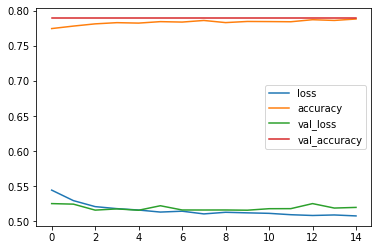

In [ ]:
pd.DataFrame(result.history).plot()

In [ ]:
model.evaluate(X_test, y_test)

188/188 [==============================] - 1s 5ms/step - loss: 0.5155 - accuracy: 0.7890


[0.5155103802680969, 0.7889999747276306]

CNN-LSTM (Seq2Seq)

In [ ]:
model = Sequential([
    Conv1D(filters=256, kernel_size=2, activation='relu',
	          input_shape=(window_size, n_features), padding="same"),
    MaxPooling1D(pool_size=2), # 중요한 정보만 남김
    Conv1D(filters=512, kernel_size=2, activation='relu', padding="same"),
    MaxPooling1D(pool_size=2),
    Flatten(),  # 펼침
    RepeatVector(window_size), # 펼친 벡터를 LSTM에다가 각각 입력으로 넣음.
    LSTM(units=lstm_units,
         dropout=.1,
         recurrent_dropout=.1,
         return_sequences=False),
    Dense(dense_units),
    Dense(output_size, activation='sigmoid')
])

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 6, 256)            4352      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 3, 256)           0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 3, 512)            262656    
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 1, 512)           0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 repeat_vector_2 (RepeatVect  (None, 6, 512)          

In [ ]:
model.compile(loss='binary_crossentropy',
              metrics=['accuracy'], optimizer='adam')

In [ ]:
result = model.fit(X_train,
                 y_train,
                 epochs=100,
                 batch_size=128,
                 shuffle=False,
                 validation_data=(X_test, y_test),
                 callbacks=[early_stopping],
                 verbose=1)

Epoch 1/100
188/188 [==============================] - 82s 422ms/step - loss: 0.5464 - accuracy: 0.7752 - val_loss: 0.5172 - val_accuracy: 0.7890
Epoch 2/100
188/188 [==============================] - 79s 419ms/step - loss: 0.5388 - accuracy: 0.7763 - val_loss: 0.5155 - val_accuracy: 0.7890
Epoch 3/100
188/188 [==============================] - 79s 418ms/step - loss: 0.5383 - accuracy: 0.7763 - val_loss: 0.5153 - val_accuracy: 0.7890
Epoch 4/100
188/188 [==============================] - 78s 417ms/step - loss: 0.5412 - accuracy: 0.7763 - val_loss: 0.5304 - val_accuracy: 0.7890
Epoch 5/100
188/188 [==============================] - 79s 418ms/step - loss: 0.5388 - accuracy: 0.7763 - val_loss: 0.5160 - val_accuracy: 0.7890
Epoch 6/100
188/188 [==============================] - 79s 418ms/step - loss: 0.5366 - accuracy: 0.7763 - val_loss: 0.5153 - val_accuracy: 0.7890
Epoch 7/100
188/188 [==============================] - 78s 418ms/step - loss: 0.5357 - accuracy: 0.7763 - val_loss: 0.5164 -

In [ ]:
pd.DataFrame(result.history).plot()

In [ ]:
model.evaluate(X_test, y_test)